In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetV2L
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import image_dataset_from_directory
from keras.layers import (Dense, Conv2D, MaxPool2D, Dropout, 
                          Flatten, GlobalAveragePooling2D, Rescaling)

In [2]:
sns.set_theme(style='darkgrid')

In [3]:
np.random.seed(42)

In [4]:
# path to files on Adam's local machine
train_path = 'data/seg_train/'
test_path = 'data/seg_test/'

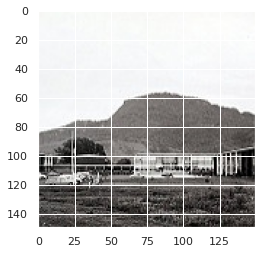

In [5]:
plt.imshow(plt.imread(train_path + 'buildings/0.jpg'));

Here is a building from the buildings Collection

## Modeling

### ImageDataGenerator

We'll use the `ImageDataGenerator` class to handle rescaling our data to be between 0 and 1 rather than between 0 and 255. You can read more about the `ImageDataGenerator` class in the documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

In [6]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

### Train and Test Data

80% train/test split with shuffle

In [8]:
#Inferring labels goes in alphanumeric order, so will match our class names
train_data = image_dataset_from_directory(directory=train_path,
                                         labels='inferred',
                                         label_mode='categorical',
                                         class_names=class_names,
                                         color_mode='rgb',
                                         batch_size=32,
                                         image_size=(150, 150),
                                         validation_split=.2,
                                         subset='training',
                                         shuffle=True,
                                         seed=42)

test_data = image_dataset_from_directory(directory=train_path,
                                         labels='inferred',
                                         label_mode='categorical',
                                         class_names=class_names,
                                         color_mode='rgb',
                                         batch_size=32,
                                         image_size=(150, 150),
                                         validation_split=.2,
                                         subset='validation',
                                         shuffle=True,
                                         seed=42)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


### Basic Network

We'll fit a basic convolutional neural network to start with.

In [9]:
# instantiate the model
basic_model = Sequential()

#Rescale our data so color values are between 0 and 1
basic_model.add(Rescaling(1./255))

# this is the fancy stuff!
# 16 different 3-by-3 filters that pick up on patterns in the images
basic_model.add(Conv2D(filters=16,  # number of filters
                     kernel_size=(3, 3), # height/width of filter
                     activation='relu', # activation function
                     ))
# reduce the dimensionality inside the CNN
basic_model.add(MaxPool2D(pool_size=(2, 2))) # dimensions of region of pooling

# before this information inside the NN is 3-d -- to connec to a Dense
# layer, we need to squash it
basic_model.add(Flatten())

# let it learn a little more...
basic_model.add(Dense(100, activation='relu'))

# output layer
basic_model.add(Dense(6, activation='softmax'))

In [10]:
# compile
basic_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

In [12]:
# fit
basic_history = basic_model.fit(train_data,
                                validation_data=test_data,
                                epochs=9,
                                verbose=1)

Epoch 1/9
351/351 [==============================] - 2s 6ms/step - loss: 0.0384 - accuracy: 0.9935 - val_loss: 1.3848 - val_accuracy: 0.7153
Epoch 2/9
351/351 [==============================] - 2s 7ms/step - loss: 0.0286 - accuracy: 0.9958 - val_loss: 1.5794 - val_accuracy: 0.7153
Epoch 3/9
351/351 [==============================] - 2s 7ms/step - loss: 0.0232 - accuracy: 0.9978 - val_loss: 1.5496 - val_accuracy: 0.7245
Epoch 4/9
351/351 [==============================] - 2s 7ms/step - loss: 0.0367 - accuracy: 0.9911 - val_loss: 2.0015 - val_accuracy: 0.6828
Epoch 5/9
351/351 [==============================] - 2s 7ms/step - loss: 0.0527 - accuracy: 0.9868 - val_loss: 1.8391 - val_accuracy: 0.6793
Epoch 6/9
351/351 [==============================] - 2s 7ms/step - loss: 0.0343 - accuracy: 0.9920 - val_loss: 1.8650 - val_accuracy: 0.6900
Epoch 7/9
351/351 [==============================] - 2s 7ms/step - loss: 0.0412 - accuracy: 0.9905 - val_loss: 1.8137 - val_accuracy: 0.6878
Epoch 8/9
351

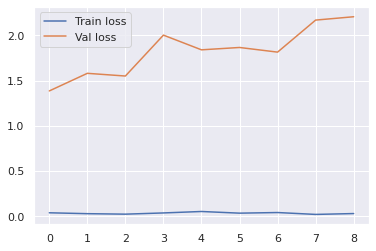

In [13]:
plt.plot(basic_history.history['loss'], label='Train loss')
plt.plot(basic_history.history['val_loss'], label='Val loss')
plt.legend();
plt.show()

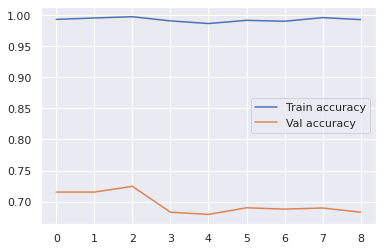

In [14]:
plt.plot(basic_history.history['accuracy'], label='Train accuracy')
plt.plot(basic_history.history['val_accuracy'], label='Val accuracy')
plt.legend();
plt.show()

This model doesn't seem to be performing very well

### Prebuilt Networks

Today we'll use `EfficientNet`. You can read more about the keras implementation of `EfficientNet` [here](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#:~:text=Keras%20implementation%20of%20EfficientNet).

#### Import EfficientNet and freeze

In [15]:
#top = false so we don't get the output layer of effnet
effnet = EfficientNetV2L(include_top=False, weights='imagenet')

In [16]:
effnet.trainable = False
effnet.trainable

False


#### Add EfficientNet to a Sequential model

Between `EfficientNet` and our first Dense layer, we will need to use `GlobalAveragePooling2D()`. (This appears to be related to a bug inside of keras; you can read more [here](https://stackoverflow.com/questions/48851558/tensorflow-estimator-valueerror-logits-and-labels-must-have-the-same-shape).)

In [17]:
eff_model = Sequential()
eff_model.add(effnet)
eff_model.add(GlobalAveragePooling2D())
eff_model.add(Dense(6, activation='softmax'))

In [18]:
eff_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (Functiona  (None, None, None, 1280)  117746848
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 117,754,534
Trainable params: 7,686
Non-trainable params: 117,746,848
_________________________________________________________________


#### Compile and evaluate

In [19]:
eff_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [20]:
eff_history = eff_model.fit(train_data, validation_data=test_data, epochs=10)

Epoch 1/10
351/351 [==============================] - 52s 100ms/step - loss: 1.1717 - accuracy: 0.6575 - val_loss: 0.7577 - val_accuracy: 0.8357
Epoch 2/10
351/351 [==============================] - 29s 83ms/step - loss: 0.6484 - accuracy: 0.8325 - val_loss: 0.5315 - val_accuracy: 0.8660
Epoch 3/10
351/351 [==============================] - 29s 83ms/step - loss: 0.5048 - accuracy: 0.8555 - val_loss: 0.4439 - val_accuracy: 0.8753
Epoch 4/10
351/351 [==============================] - 29s 83ms/step - loss: 0.4414 - accuracy: 0.8636 - val_loss: 0.3968 - val_accuracy: 0.8813
Epoch 5/10
351/351 [==============================] - 29s 83ms/step - loss: 0.3988 - accuracy: 0.8726 - val_loss: 0.3675 - val_accuracy: 0.8842
Epoch 6/10
351/351 [==============================] - 29s 83ms/step - loss: 0.3717 - accuracy: 0.8779 - val_loss: 0.3467 - val_accuracy: 0.8917
Epoch 7/10
351/351 [==============================] - 29s 83ms/step - loss: 0.3538 - accuracy: 0.8822 - val_loss: 0.3318 - val_accuracy

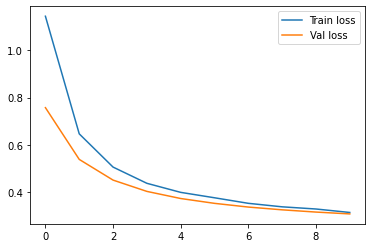

In [33]:
plt.plot(eff_history.history['loss'], label='Train loss')
plt.plot(eff_history.history['val_loss'], label='Val loss')
plt.legend();
plt.show()

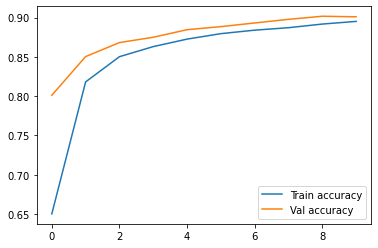

In [34]:
plt.plot(eff_history.history['accuracy'], label='Train accuracy')
plt.plot(eff_history.history['val_accuracy'], label='Val accuracy')
plt.legend();
plt.show()

It looks like this could train for a little while longer but we'll call it good here for fear of overfitting

# Confusion matrix
First create some data for it:

In [18]:
all_data = image_dataset_from_directory(directory=train_path,
                                        labels='inferred',
                                        label_mode='categorical',
                                        class_names=class_names,
                                        color_mode='rgb',
                                        batch_size=32,
                                        image_size=(150, 150),
                                        shuffle=False,
                                        seed=42)

Found 14034 files belonging to 6 classes.


In [40]:
y = np.concatenate([y for x, y in all_data], axis=0)

y_pred_array = eff_model.predict(all_data)
y_pred = np.argmax(y_pred_array, axis=1)

#Create confusion matrix
print('Confusion Matrix')
matrix = confusion_matrix(np.where(y==1)[1], y_pred,normalize='true')
print(matrix)
print('Classification Report')
print(classification_report(np.where(y==1)[1], y_pred, 
                            target_names=class_names))

439/439 [==============================] - 57s 129ms/step
Confusion Matrix
[[8.89548152e-01 4.56412597e-03 1.82565039e-03 1.04974897e-02
  9.12825194e-03 8.44363304e-02]
 [1.32100396e-03 9.81946279e-01 8.80669309e-04 1.10083664e-02
  3.08234258e-03 1.76133862e-03]
 [3.74376040e-03 9.56738769e-03 8.05324459e-01 1.33943428e-01
  4.40931780e-02 3.32778702e-03]
 [1.19426752e-03 3.98089172e-03 1.39331210e-01 8.34394904e-01
  2.03025478e-02 7.96178344e-04]
 [6.59630607e-03 3.95778364e-03 1.75901495e-02 1.05540897e-02
  9.58663149e-01 2.63852243e-03]
 [4.99580185e-02 2.93870697e-03 4.19815281e-04 5.03778338e-03
  3.35852225e-03 9.38287154e-01]]
Classification Report
              precision    recall  f1-score   support

   buildings       0.93      0.89      0.91      2191
      forest       0.97      0.98      0.98      2271
     glacier       0.83      0.81      0.82      2404
    mountain       0.84      0.83      0.84      2512
         sea       0.92      0.96      0.94      2274
      s

## Create heatmap 

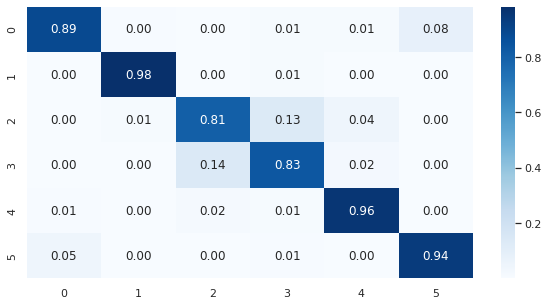

In [59]:
sns.set(rc = {'figure.figsize':(10,5)})
sns.heatmap(matrix, annot=True,fmt='.2f', cmap="Blues");

### Can you tell the difference between these pictures? Our model can!

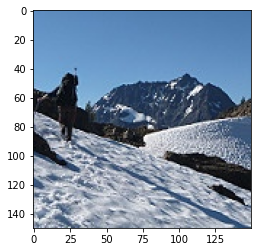

In [24]:
mountain = random.choice(os.listdir("data/seg_train/mountain"))
plt.imshow(plt.imread(f'data/seg_train/mountain/{mountain}'));
plt.show()

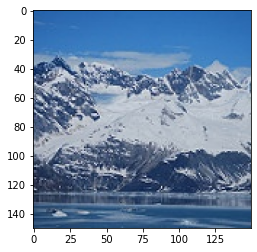

In [13]:
glacier = random.choice(os.listdir("data/seg_train/glacier"))
plt.imshow(plt.imread(f'data/seg_train/glacier/{glacier}'));
plt.show()

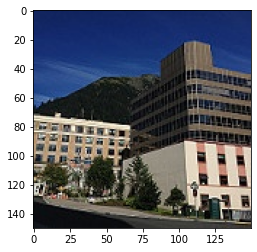

In [31]:
buildings = random.choice(os.listdir("data/seg_train/buildings"))
plt.imshow(plt.imread(f'data/seg_train/buildings/{buildings}'));
plt.show()

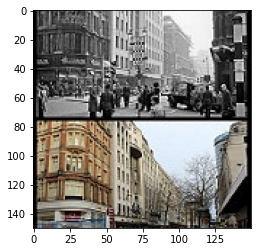

In [29]:
street = random.choice(os.listdir("data/seg_train/street"))
plt.imshow(plt.imread(f'data/seg_train/street/{street}'));
plt.show()

In [60]:
100/6

16.666666666666668